\begin{align}
  p(x_t \mid \mathbf{z}_t) &= \mathcal{N}\left(x_t \mid\mathbf{e}_1^{\top} \mathbf{z}_{t}, \beta \right) \,.\label{eq:HA-model-x_t} \\
  p(\mathbf{z}_t \mid \mathbf{z}_{t-1}) &= \mathcal{N}\left(\mathbf{z}_t \mid A(\boldsymbol{\theta}_t)\mathbf{z}_{t-1},  V \right) \label{eq:HA-model-z_t} \\
  p(y_t \mid \mathbf{z}_t) &= \mathcal{N}\left(y_t \mid \mathbf{e}_1^{\top} \mathbf{z}_{t}, \sqrt{\omega}\beta \right) \label{eq:HA-model-y_t} 
\end{align}

In [1]:
##
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov, Multivariate
using LAR.Node
using LAR.Data
using ProgressMeter
using LinearAlgebra
using Plots
using Dates
using WAV

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260


In [35]:
# clean speech
cl, fs = wavread("speech/clean.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "speech/noised.wav")

In [6]:
using SampledSignals
# clean speech
buf_cl = SampleBuf{Float64, 2}(cl, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▁▁▁▁▁▂▅▅▅▅▅▅▆▆▆▆▆▆▅▄▅▅▄▄▄▄▂▄▆▆▆▆▆▆▆▅▄▅▅▅▄▆▆▆▆▅▄▅▅▅▆▅▅▅▅▆▆▆▆▃▃▁▁▄▄▅▅▅▄▂▃▂▂▂▂▂▂▁▁▁

In [7]:
# noised speech
buf_ns = SampleBuf{Float64, 2}(ns, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▅▄▅▆▅▄▄▅▄▄▆▆▆▆▆▆▆▆▄▅▅▅▄▆▆▆▆▅▅▅▅▅▆▅▅▅▅▆▆▆▆▄▄▄▄▄▄▅▆▅▄▄▄▄▄▄▄▄▄▄▄▄

In [31]:
# dividing into 10ms frames with 2.5ms overlap
start = 1
l = Int(0.01*fs)
overlap = Int(0.0025*fs)
totseg = Int(ceil(length(ns)/(l-overlap)))
segment = zeros(totseg, l)
zseg = zeros(totseg, l)
for i in 1:totseg - 1
    global start
    segment[i,1:l]=ns[start:start+l-1]
    zseg[i, 1:l] = cl[start:start+l-1]
    start = (l-overlap)*i+1
end
segment[totseg, 1:length(ns)-start+1] = ns[start:length(ns)]
zseg[totseg, 1:length(cl)-start+1] = cl[start:length(cl)]
n_samples = l;

In [87]:
# Building the model
ARorder = 8
fg = FactorGraph()

# State prior
@RV z_0 ~ GaussianMeanVariance(placeholder(:m_z_0, dims=(ARorder, )),
                               placeholder(:v_z_0, dims=(ARorder, ARorder)))

@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                             placeholder(:v_θ, dims=(ARorder, ARorder)))

@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Transition
z = Vector{Variable}(undef, n_samples)
z1 = Vector{Variable}(undef, n_samples)
# Input
x = Vector{Variable}(undef, n_samples)
x1 = Vector{Variable}(undef, n_samples)
# Output
y = Vector{Variable}(undef, n_samples)
# Intervention
ω = Vector{Variable}(undef, n_samples)
ωτ = Vector{Variable}(undef, n_samples)

c = zeros(ARorder); c[1] = 1.0

z_i_min = z_0
for i in 1:n_samples
    
    @RV z[i] ~ Autoregressive(θ, z_i_min, γ)
    
    @RV x1[i] = dot(c, z[i])

    @RV x[i] ~ GaussianMeanPrecision(x1[i], τ)
    
    @RV ω[i]
    
    @RV ωτ[i] = ω[i]*τ
    
    @RV z1[i] = dot(c, z[i])
    
    @RV y[i] ~ GaussianMeanPrecision(z1[i], ωτ[i])
    

    # Data placeholder
    placeholder(y[i], :y, index=i)
    placeholder(ω[i], :ω, index=i)
    placeholder(x[i], :x, index=i)

    # Reset state for next step
    z_i_min = z[i]
end

In [88]:
q = PosteriorFactorization(z_0, z, γ, θ, τ, ids=[:Z0 :Z :Γ :Θ :T])
algo = messagePassingAlgorithm(free_energy=true)
src_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(src_code));

In [89]:
# VMP iterations
vmp_its = 10

# Storage for results
fe = zeros(totseg, vmp_its)

rmz = zeros(totseg, l)
rvz = zeros(totseg, l)

rmθ = zeros(totseg, ARorder)
rvθ = zeros(ARorder, ARorder, totseg)

rγ_a, rγ_b = zeros(totseg), zeros(totseg)
rτ_a, rτ_b = zeros(totseg), zeros(totseg)

# Priors
m_z_min_0 = randn(ARorder)
v_z_min_0 = diagm(ones(ARorder))
m_θ_min_0 = randn(ARorder)
v_θ_min_0 = diagm(ones(ARorder))
a_γ_0 = 1.0
b_γ_0 = 0.001
a_τ_0 = 1.0
b_τ_0 = σ²;
ω = ones(l);

In [90]:
@showprogress for segnum in 1:totseg
    global rmz, rvz, rmθ, rvθ, rγ, m_z_min_0, v_z_min_0, m_θ_min_0, v_θ_min_0, a_γ_0, b_γ_0, a_τ_0, b_τ_0, vmp_its

    obs = segment[segnum, :]
    n_samples = length(ns)

    data = Dict(:y => obs .+ sqrt(0.001)*randn(length(obs)), :x=>obs, :m_z_0 => m_z_min_0, :v_z_0 => v_z_min_0,
                :m_θ => m_θ_min_0, :v_θ => v_θ_min_0,
                :a_γ => a_γ_0, :b_γ => b_γ_0, :a_τ => a_τ_0, :b_τ => b_τ_0, :ω => ω)

    # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}()
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=m_θ_min_0, v=v_θ_min_0)
    marginals[:γ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_γ_0, b=b_γ_0)
    marginals[:τ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_τ_0, b=b_τ_0)
    for i in 0:n_samples
        marginals[:ωτ_*i] = ProbabilityDistribution(ForneyLab.Univariate, Gamma, a=a_τ_0, b=b_τ_0/data[:ω][l])
        marginals[:z_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
    end

    # Run algorithm
    for i in 1:vmp_its
        stepZ0!(data, marginals)
        stepZ!(data, marginals)
        stepΘ!(data, marginals)
        stepT!(data, marginals)
        stepΓ!(data, marginals)
        fe[segnum, i] = freeEnergy(data, marginals)
    end

    m_z = [unsafeMean(marginals[Symbol("z_$(i+1)_z_$(i)")])[1] for i in 2:length(obs)-1]
    v_z = [unsafeCov(marginals[Symbol("z_$(i+1)_z_$(i)")])[1] for i in 2:length(obs)-1]
    insert!(m_z, 1, unsafeMean(marginals[:z_1])[1])
    insert!(m_z, 1, unsafeMean(marginals[:z_0])[1])
    insert!(v_z, 1, unsafeCov(marginals[:z_1])[1])
    insert!(v_z, 1, unsafeCov(marginals[:z_0])[1])

    rmz[segnum, :], rvz[segnum, :] = m_z, v_z
    rmθ[segnum, :], rvθ[:, :, segnum] = unsafeMeanCov(marginals[:θ])
    rγ_a[segnum], rγ_b[segnum] = marginals[:γ].params[:a], marginals[:γ].params[:b]
    rτ_a[segnum], rτ_b[segnum] = marginals[:τ].params[:a], marginals[:τ].params[:b]

    m_z_min_0, v_z_min_0 = unsafeMean(marginals[:z_*ARorder]), unsafeCov(marginals[:z_*ARorder])
    m_θ_min_0, v_θ_min_0 = unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]) + Matrix{Float64}(I, ARorder, ARorder)
    a_τ_0, b_τ_0 = rτ_a[segnum], rτ_b[segnum]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:27


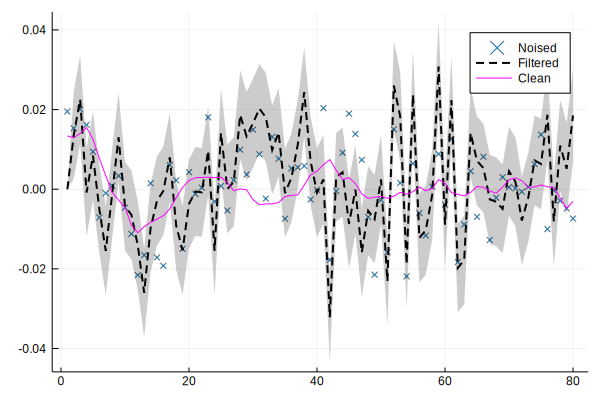

In [91]:
# Plotting segment
segnum = 300

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmz[segnum, :], ribbon=sqrt.(rvz[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean")

In [92]:
findmin(fe[:, end])

(-312.54677460246, 267)